# Practical work 4: Frequency filtering, color

In [119]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift
import matplotlib.pyplot as plt
from PIL import Image
import os
import imageio

def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()
    


## Exercice 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of `img/mandrill.png` (use functions seen in previous lessons). 

Text(0.5, 1.0, 'FFT')

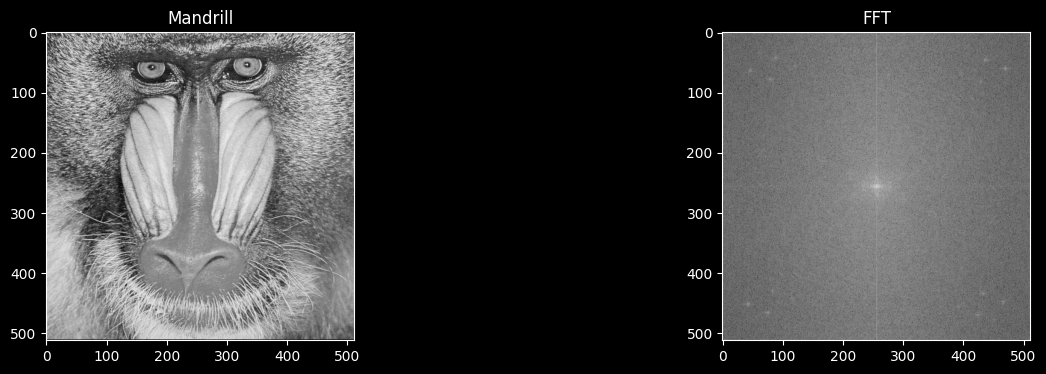

In [2]:
singe = np.array(Image.open('img/mandrill.png'))
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(singe,cmap="gray")
ax.set_title("Mandrill")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(singe)))),cmap="gray")
ax.set_title('FFT')

2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at Euclidian distance $f_c$ from the center (null frequency).

In [3]:
def idealLowPassFilter(n,m,fc) :
    centreX = int(n/2.0)
    centreY = int(m/2.0)
    H = np.zeros((n,m))
    for i in range(n) :
        for j in range(m) :
            
            if np.sqrt((i-centreX)**2+(j-centreY)**2) <= fc :
                
                H[i][j] = 1
    
    return H

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (use function `ifft2()` from module `numpy.fft`)
 - return the real part of filtered image

In [4]:
def lowPass(I,fc) :
    ftI = np.fft.fftshift(np.fft.fft2(I))
    filtre = idealLowPassFilter(I.shape[0], I.shape[1], fc)
    mult = filtre * ftI

    return np.real(np.fft.ifft2(np.fft.fftshift(mult)))
    

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


In [5]:
def PSNR(I1,I2):
    return 10 * np.log10(255**2 / (np.linalg.norm(I2-I1, ord=2)) )

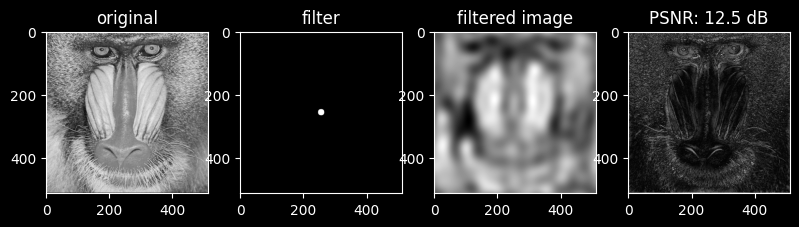

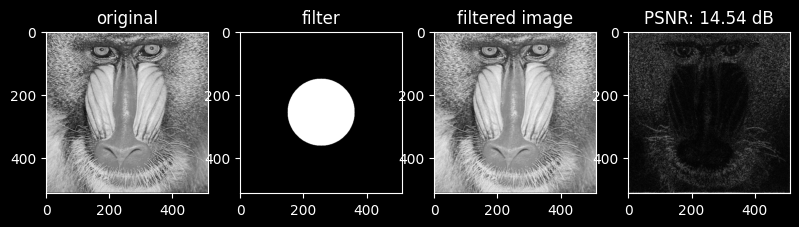

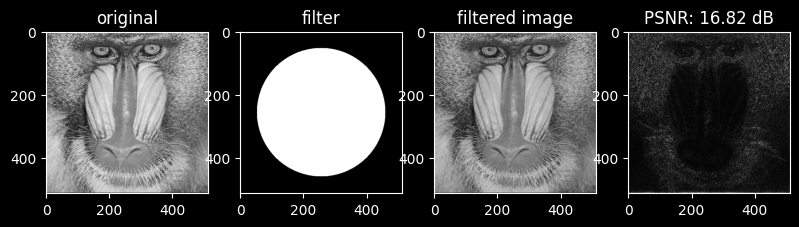

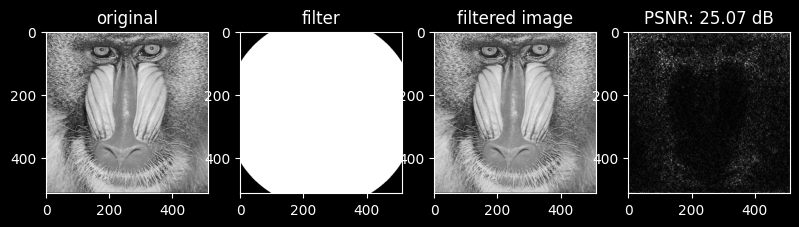

In [6]:
nb_pass=400

def lowPassFiltering(I,fc,nb_pass):
    tmp_arr=np.linspace(10,fc,nb_pass).astype(int)

    for i in tmp_arr:
        filtered_pic = lowPass(singe, i)
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax = fig.add_subplot(1, 4, 1)
        ax.imshow(singe,cmap="gray")
        ax.set_title("original")
        ax = fig.add_subplot(1, 4, 2)
        ax.imshow(idealLowPassFilter(512,512,i),cmap="gray")
        ax.set_title('filter')
        ax = fig.add_subplot(1, 4, 3)
        ax.imshow(filtered_pic,cmap="gray")
        ax.set_title('filtered image')
        ax = fig.add_subplot(1, 4, 4)
        ax.imshow(np.abs(singe-filtered_pic),cmap="gray")
        ax.set_title('PSNR: '+ str(np.around(PSNR(singe,filtered_pic),2))+" dB")
        #txt ='PSNR: '+ str(np.around(PSNR(singe,filtered_pic),2))+" dB"
        #plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

lowPassFiltering(singe, 300, 4)

## Exercice 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

Filtre de taille d*d. Si on centre le filtre sur le pixel en haut à droite de l'image, il faut avoir autant de pixels du filtre d'un côté ou de l'autre du pixel. Donc il faut rajouter (d-1)/2 lignes et colonnes de chaque côté de l'image.

2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1. It is not allowed to use a module implementing the padding.

In [96]:
def imagePad(I,h) :
    nb = int((h.shape[0] - 1) / 2.0)
    mat1 = np.hstack((np.zeros((I.shape[0], nb)), I, np.zeros((I.shape[0], nb))))
    mat2 = np.vstack((np.zeros((nb, mat1.shape[1])), mat1, np.zeros((nb, mat1.shape[1]))))
    return mat2

dimensions :  (512, 512)  et  (526, 526)


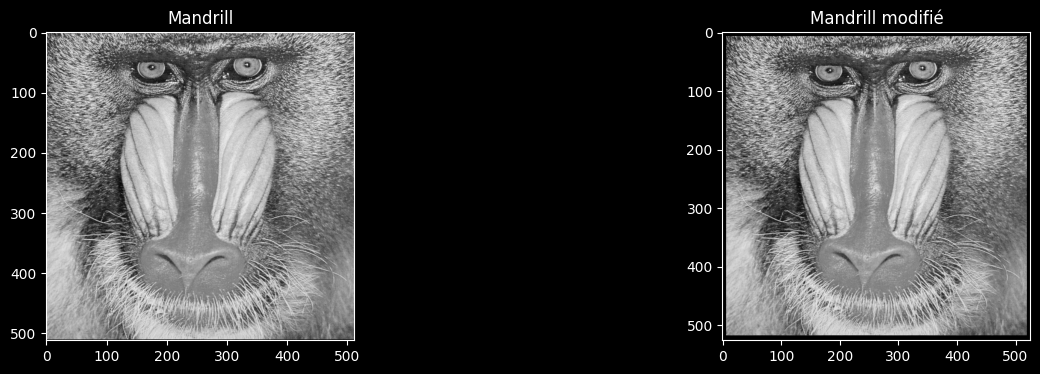

In [104]:
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(singe,cmap="gray")
ax.set_title("Mandrill")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(imagePad(singe,np.zeros((15,15))),cmap="gray")
ax.set_title("Mandrill modifié")
print("dimensions : ", singe.shape," et ", imagePad(singe,np.zeros((15,15))).shape)

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [112]:
def conv2(I,h) :

    if (h.shape[0] % 2 == 0) or (h.shape[1] % 2 == 0) :
        raise ValueError("h must have odd dimensions")
        
    res = imagePad(I.copy(),h)
    
    n = int((h.shape[0]-1)/2.0)
    for i in range(n,I.shape[0]+n):
        for j in range(n,I.shape[1]+n):
            res[i][j]=np.mean(res[i-n:i+n+1,j-n:j+n+1]*h)
    return res[n:-n,n:-n]
        

4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

Text(0.5, 1.0, 'Mandrill modifié')

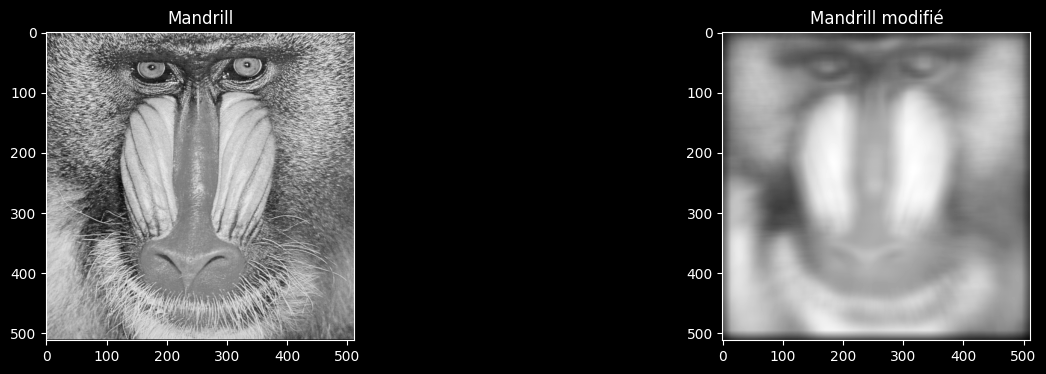

In [114]:
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(singe,cmap="gray")
ax.set_title("Mandrill")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(conv2(singe,np.ones((31,31))),cmap="gray")
ax.set_title("Mandrill modifié")

In [126]:
display_gif("smoothing_test.gif")

5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

Text(0.5, 1.0, 'Mandrill modifié')

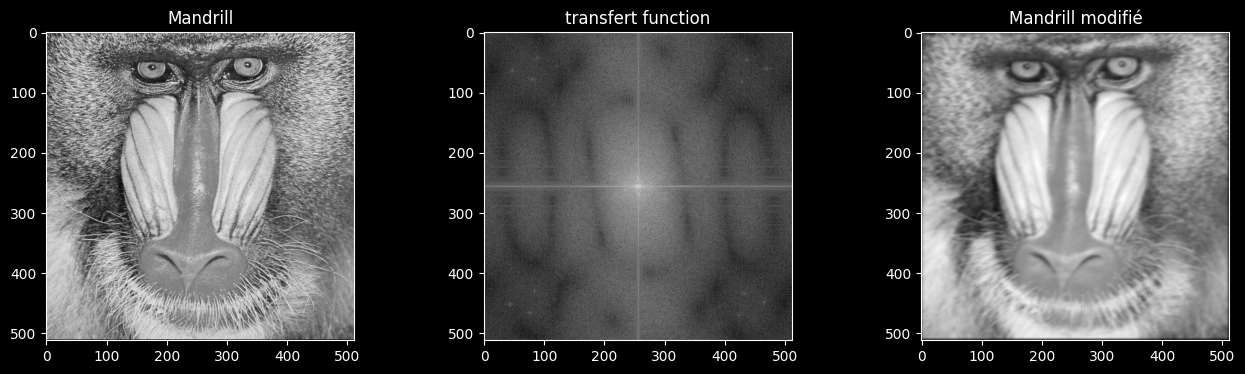

In [144]:
kernel_size=7
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(singe,cmap="gray")
ax.set_title("Mandrill")
ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(conv2(singe,np.ones((kernel_size,kernel_size))))))),cmap="gray")
ax.set_title("transfert function")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(conv2(singe,np.ones((kernel_size,kernel_size))),cmap="gray")
ax.set_title("Mandrill modifié")

6. Interpretation: what is the analytic expression of the transfert function of a mean filter? Is  it an ideal low pass filter?

7. Bonus question: perform the same study for the Gaussian kernel. Determine $\sigma$ in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

In [1]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()
### your answer start below


## Exercice 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

In [ ]:
def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A
### your answer start below


3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

## Exercice 4: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images examine their shape. What difference there are between them?

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

4. Write a code that allows the see the first channel with red color scales, the second channel in green color scales, and the blue channel in blue color scales.

Utilitaires

In [123]:
nb_images=32

w,h=400,400

for i in range(1,nb_images,2):

    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(singe,cmap="gray")
    ax.set_title("original")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(conv2(singe,np.ones((i,i))),cmap="gray")
    ax.set_title("mean filter : ("+str(i)+"x"+str(i)+")")   
    
    

    

    plt.savefig('gen_gif_'+str(i)+'.png')
    plt.close()

/var/folders/7t/84clpkws78x2jhnt808jfvz00000gn/T/ipykernel_34889/1888492380.py:12: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(conv2(singe,np.ones((i,i))),cmap="gray")
/var/folders/7t/84clpkws78x2jhnt808jfvz00000gn/T/ipykernel_34889/1888492380.py:12: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(conv2(singe,np.ones((i,i))),cmap="gray")


In [124]:
nom_gif="smoothing_test.gif"


with imageio.get_writer(nom_gif, mode='I') as writer:
    for i in range(1,nb_images,2):
        image = imageio.v2.imread('gen_gif_'+str(i)+'.png')
        writer.append_data(image)

for i in range(1,nb_images,2):
    os.remove('gen_gif_'+str(i)+'.png') 

In [125]:
display_gif(nom_gif)